<img src="data/logo-ensae.jpg"> <img src="data/logo-ipparis.jpg">

**"Techniques Avancées d'apprentissage", S2 2018-19** 
# *One-class Classification with Support Vector Machine*  

  
**Tanguy CARROUSSEL**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  
**Yosuke IJIRI**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  

# Overview
[Remark] This is the coding part of the project. Report is prepared separately from this notebook.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import utils.mnist_reader as mnist_reader
import utils.tools as tls
import PIL.Image

## 1. Data

* We use fashion-mnist data (source: https://github.com/zalandoresearch/fashion-mnist).
* There are 60000 train data and 10000 test data; each of the data (item) respresents a set of 28*28 (784) pixels with gray scale ranging from 0 to 255.

In [2]:
# Load the dataset
X_train, y_train = mnist_reader.load_mnist('./data', kind='train')
X_test, y_test = mnist_reader.load_mnist('./data', kind='t10k')
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (60000, 784)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [3]:
label_dic = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
             5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

* Two ways to visualise the images

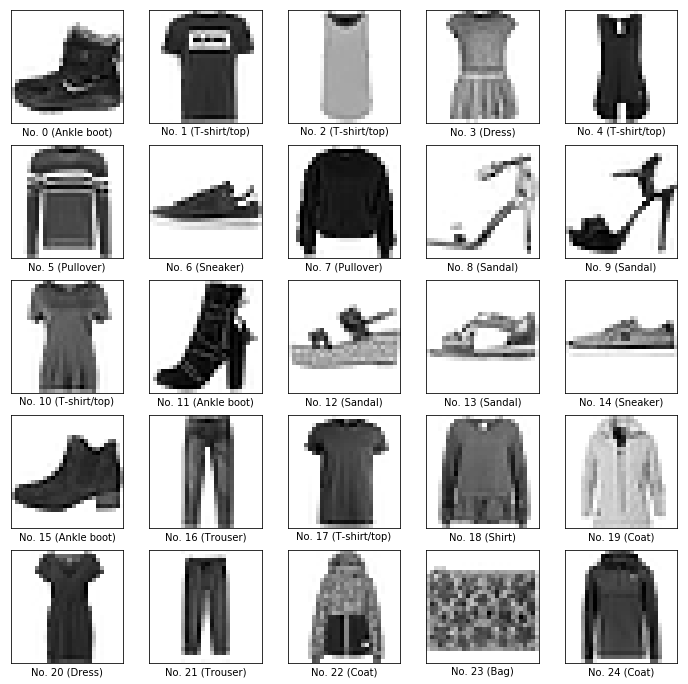

In [4]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]), plt.yticks([])
    plt.xlabel("No. %d (%s)" %(i, label_dic[y_train[i]]))
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)
#tls.save_image("./mnist/visualization/sample.png", X_train[0]) would be better to save sample outputs
#PIL.Image.fromarray(X_train.reshape((X_train.shape[0],28,28))[0]) is the visualisation part of the above saving code

In [5]:
# To check if we need to normalise the data into 0-1 range just like Neural Network.
# X_train = X_train / 255.0

There are 6000 images of ankle boots


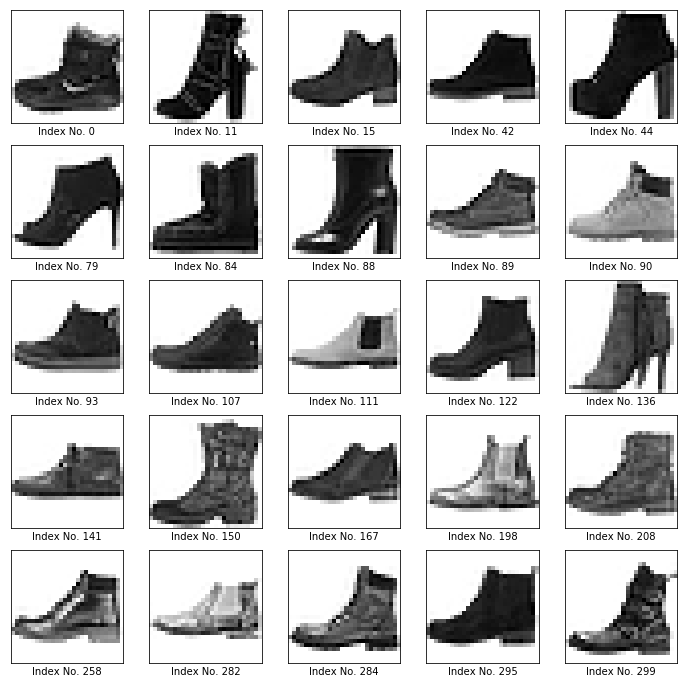

In [6]:
# Show only, for instance, Ankle boot
ankleboot_idx = [idx for idx, y in enumerate(y_train) if y == 9]
print('There are %d images of ankle boots' %len(ankleboot_idx))
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]), plt.yticks([])
    plt.xlabel("Index No. %d" %ankleboot_idx[i])
    plt.imshow(X_train[ankleboot_idx][i].reshape(28,28), cmap=plt.cm.binary)

## 2. Model

* One-class SVM

In [7]:
from sklearn import svm

In [8]:
clf = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
clf.fit(X_train[ankleboot_idx])

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [ ]:
y_pred = clf.predict(X_train)

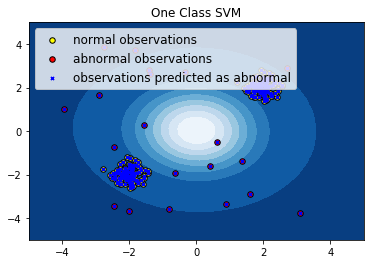

In [29]:
#Test (Code temporarily copied from a webpage just for testing)
np.random.seed(42)

# Generate train data
X = 0.3 * np.random.randn(100, 2)

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma='auto') # nu specifies the max ratio of anomaly data
clf.fit(X)

# Generate some abnormal novel observations
ANOMALY_DATA_COUNT = 20
X_outliers = np.random.uniform(low=-4, high=4, size=(ANOMALY_DATA_COUNT, 2))
X = np.r_[X + 2, X - 2, X_outliers]

y_pred = clf.predict(X)
# normal:1、abnormal:-1
ANOMALY_DATA = -1
predicted_outlier_index = np.where(y_pred == ANOMALY_DATA)
predicted_outlier = X[predicted_outlier_index]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("One Class SVM")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='yellow',
                edgecolor='k', s=30, marker='o')
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=30, marker='o')
c = plt.scatter(predicted_outlier[:, 0], predicted_outlier[:, 1], c='blue',
                edgecolor='k', s=10, marker='x')
plt.axis('tight')
plt.xlim((-5, 5)), plt.ylim((-5, 5))
plt.legend([a, b, c],
           ["normal observations",
            "abnormal observations",
            "observations predicted as abnormal"],
           loc="upper left", prop={'size': 12})
plt.show()

## 3. Result